In [1]:
!pip install xgboost

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [2]:
df=pd.read_csv("GOOGLE  BP DATA.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
1,02-04-2014,29.917362,30.158699,28.032537,28.272379,2942055.0,4.0,0.136623,3665.989990
2,03-04-2014,28.414488,29.283602,28.129271,28.409002,101983228.0,5.0,-1.326357,3637.580078
3,04-04-2014,28.653831,28.809404,27.075665,27.082645,127386783.0,6.0,-0.248817,3539.379883
4,07-04-2014,26.962973,27.348913,26.285334,26.833828,88033033.0,2.0,0.835207,3507.750000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2205 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [7]:
df.set_index('Date',inplace=True)

In [8]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
2014-02-04,29.917362,30.158699,28.032537,28.272379,2942055.0,4.0,0.136623,3665.989990
2014-03-04,28.414488,29.283602,28.129271,28.409002,101983228.0,5.0,-1.326357,3637.580078
2014-04-04,28.653831,28.809404,27.075665,27.082645,127386783.0,6.0,-0.248817,3539.379883
2014-07-04,26.962973,27.348913,26.285334,26.833828,88033033.0,2.0,0.835207,3507.750000


In [9]:
df.tail()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing entries


In [10]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [11]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [12]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [13]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [14]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [15]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


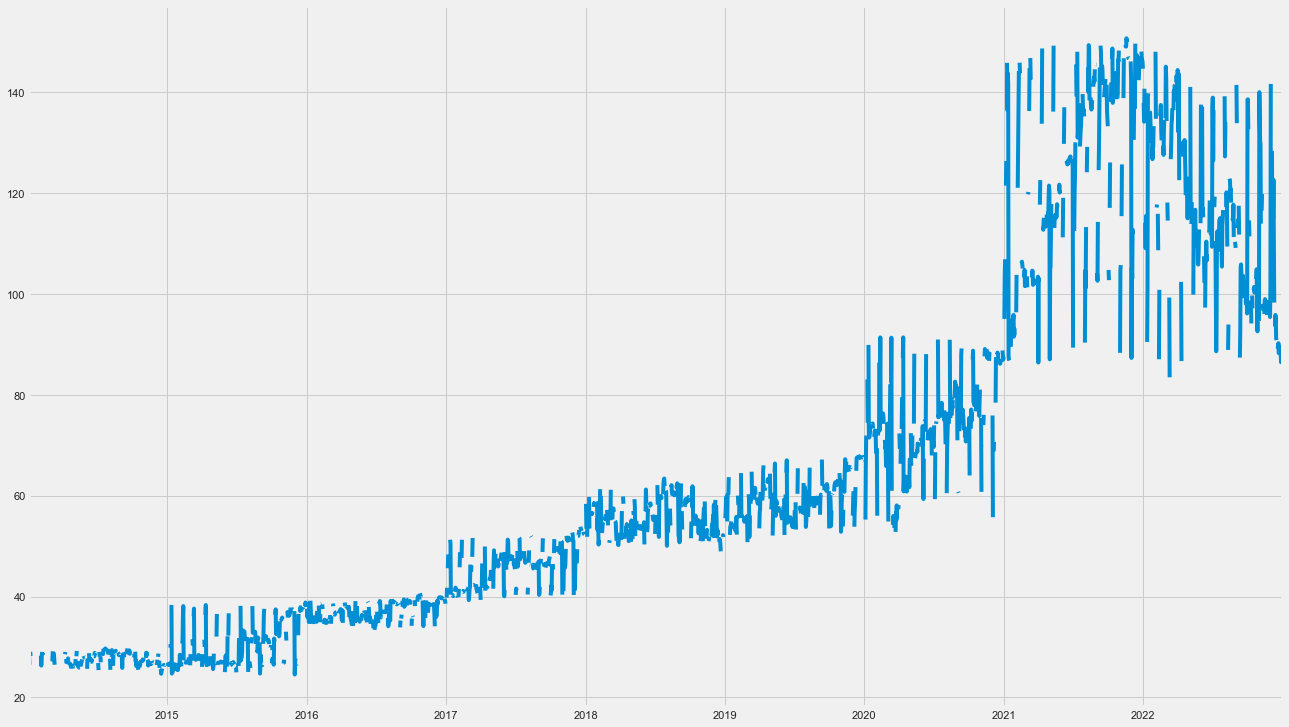

In [16]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [17]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902,28.280355
2014-01-05,26.283339,26.573542,26.122280,26.494759,38110345.0,5.0,-0.170533,3594.360107,26.494759
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,26.494759
2014-01-07,28.836828,29.139996,28.753557,29.053734,28959290.0,3.0,-0.016705,3894.330078,29.053734
2014-01-08,28.441914,28.719152,28.065447,28.226006,39105069.0,6.0,0.353031,3879.669922,28.226006
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,28.226006
2014-01-10,28.721645,28.799931,28.272877,28.335705,28909153.0,4.0,0.090252,3984.739990,28.335705
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,28.335705
2014-01-12,26.871225,26.996382,26.520189,26.616922,42307838.0,2.0,-0.002493,4287.810059,26.616922
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,26.616922


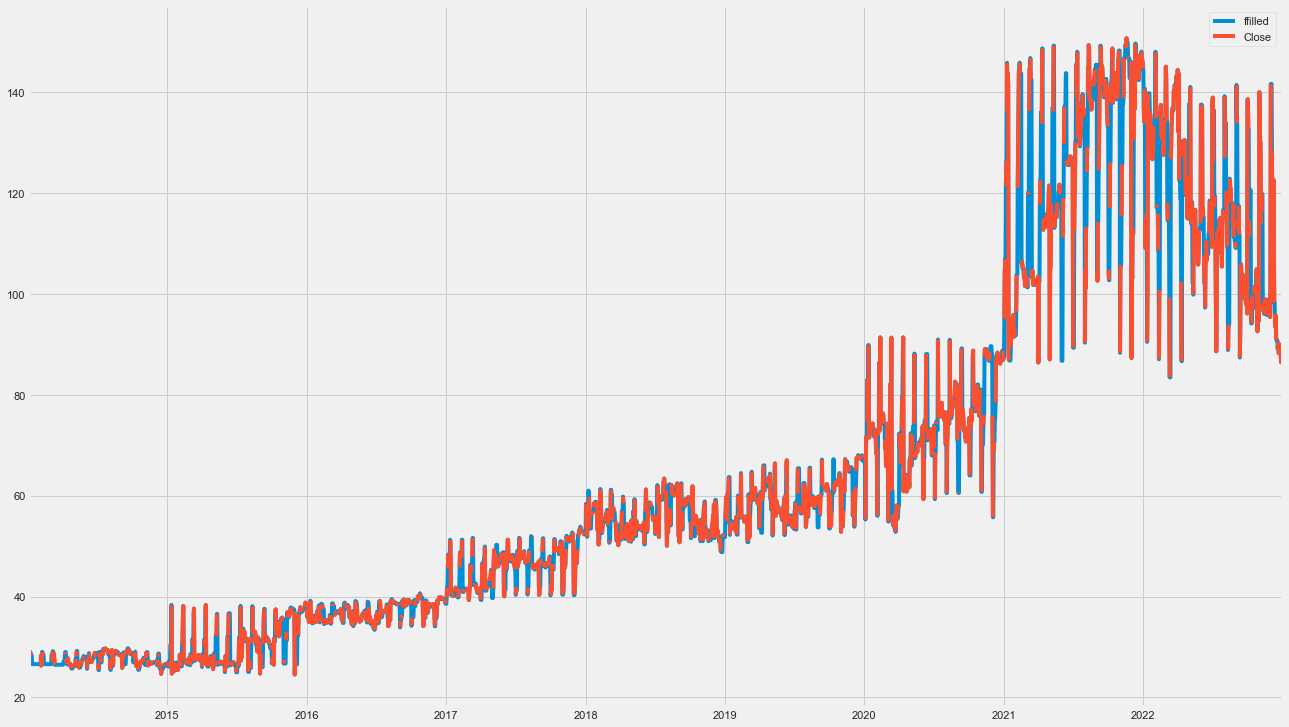

In [18]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [19]:
df.ffilled

2014-01-04    28.280355
2014-01-05    26.494759
2014-01-06    26.494759
2014-01-07    29.053734
2014-01-08    28.226006
                ...    
2022-12-26    89.809998
2022-12-27    87.930000
2022-12-28    86.459999
2022-12-29    88.949997
2022-12-30    88.730003
Name: ffilled, Length: 3283, dtype: float64

In [20]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,28.280355,28.280355,3658.399902,-0.007976
2014-01-05,26.494759,26.494759,3594.360107,-0.170533
2014-01-06,26.494759,NaN,3594.360107,NaN
2014-01-07,29.053734,29.053734,3894.330078,-0.016705
2014-01-08,28.226006,28.226006,3879.669922,0.353031
...,...,...,...,...
2022-12-26,89.809998,NaN,10985.450200,NaN
2022-12-27,87.930000,87.930000,10822.509770,-1.470001
2022-12-28,86.459999,86.459999,10679.339840,2.489998
2022-12-29,88.949997,88.949997,10951.049810,-0.219994


In [21]:
df.drop(["Close"],axis=1,inplace=True)

In [22]:
df

,close,NASDAQ,Change
2014-01-04,28.280355,3658.399902,-0.007976
2014-01-05,26.494759,3594.360107,-0.170533
2014-01-06,26.494759,3594.360107,NaN
2014-01-07,29.053734,3894.330078,-0.016705
2014-01-08,28.226006,3879.669922,0.353031
...,...,...,...
2022-12-26,89.809998,10985.450200,NaN
2022-12-27,87.930000,10822.509770,-1.470001
2022-12-28,86.459999,10679.339840,2.489998
2022-12-29,88.949997,10951.049810,-0.219994


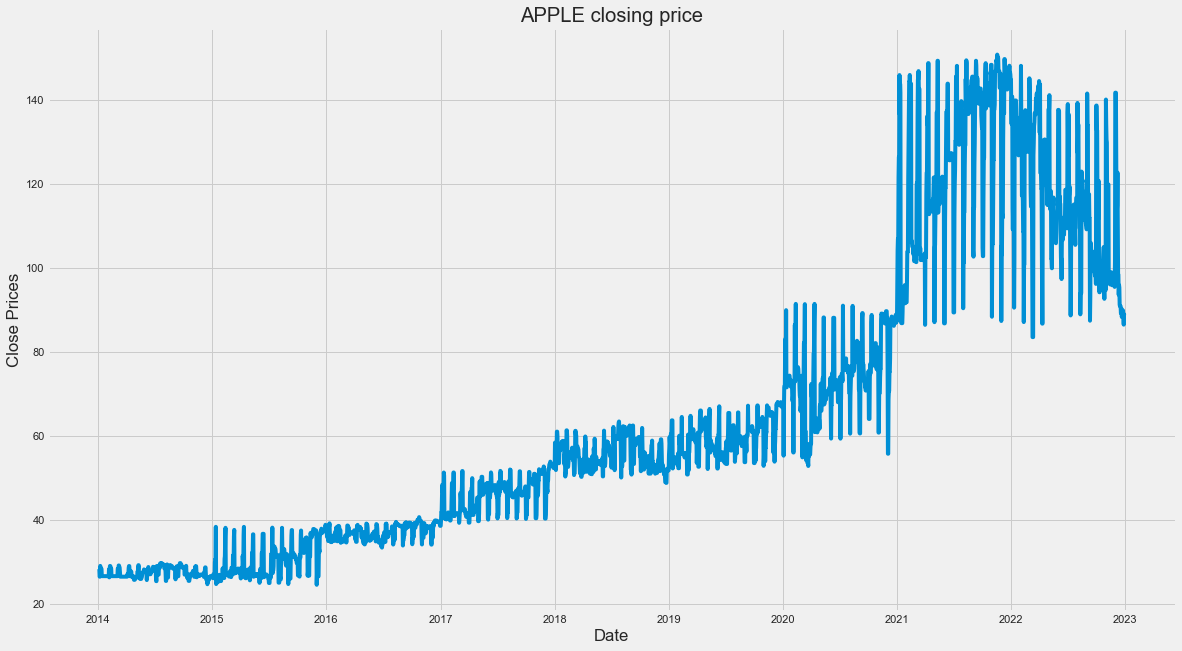

In [23]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data


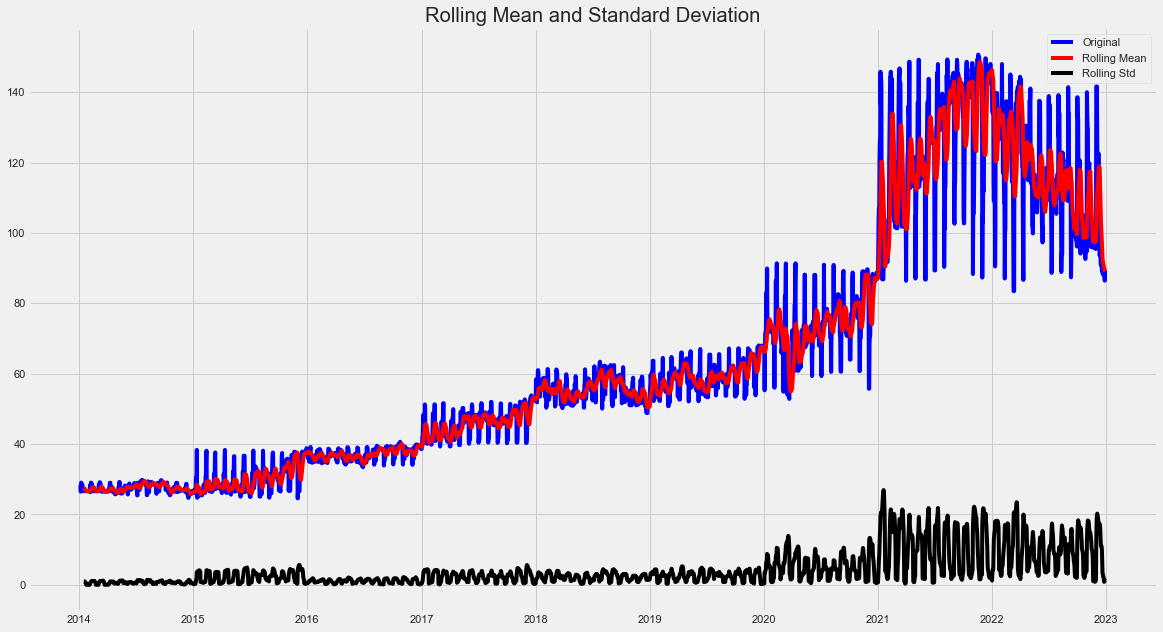

Results of dickey fuller test
Test Statistics                  -0.410916
p-value                           0.908260
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [24]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

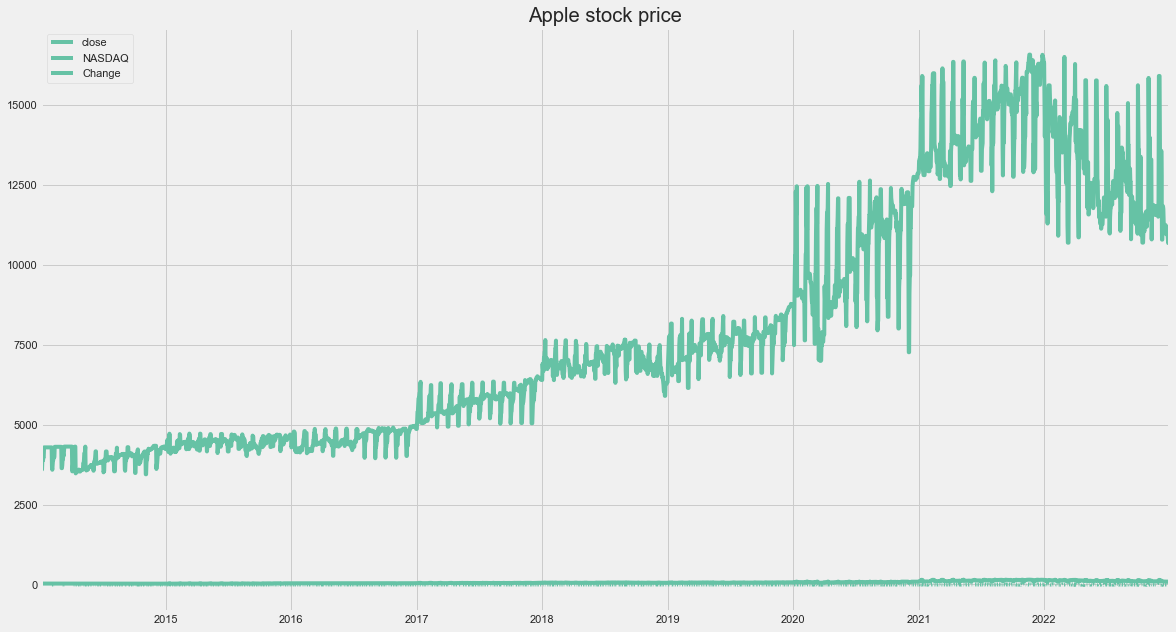

In [25]:
df.plot(style='-',
        figsize=(18, 10),
        color=color_pal[0],
        title='Apple stock price')
plt.show()

## Train / Test Split¶


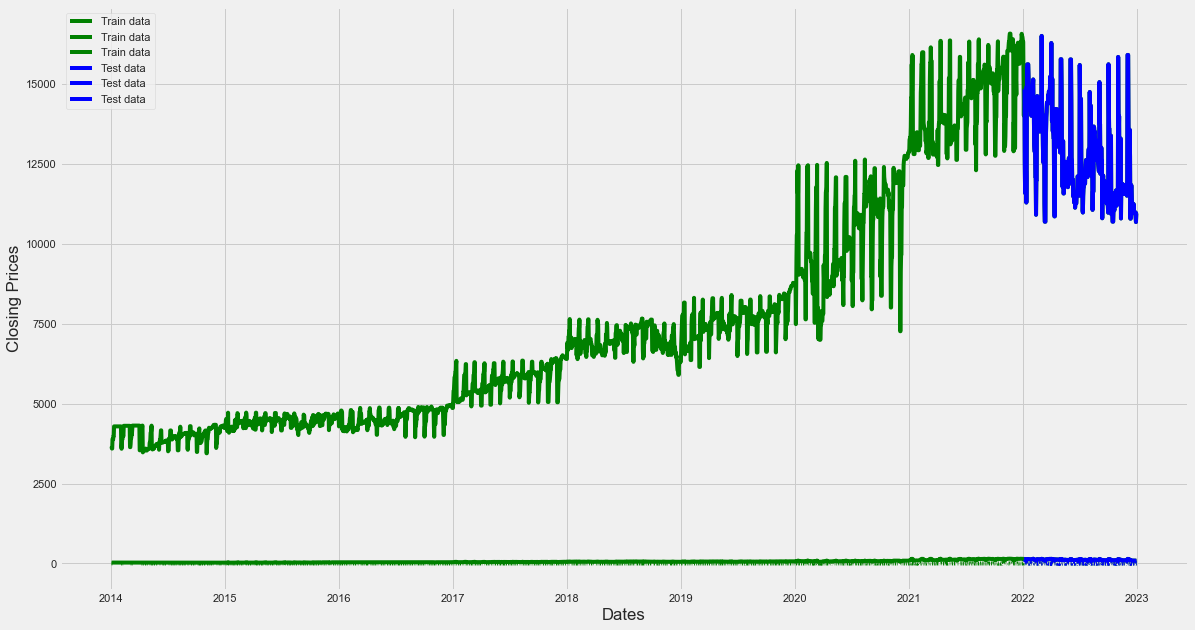

In [26]:
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [27]:
train_data.shape

(2922, 3)

In [28]:
test_data.tail()

,close,NASDAQ,Change
2022-12-26,89.809998,10985.45020,NaN
2022-12-27,87.930000,10822.50977,-1.470001
2022-12-28,86.459999,10679.33984,2.489998
2022-12-29,88.949997,10951.04981,-0.219994
2022-12-30,88.730003,10939.75977,0.969994


In [29]:
test_data.shape

(361, 3)

In [30]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship¶


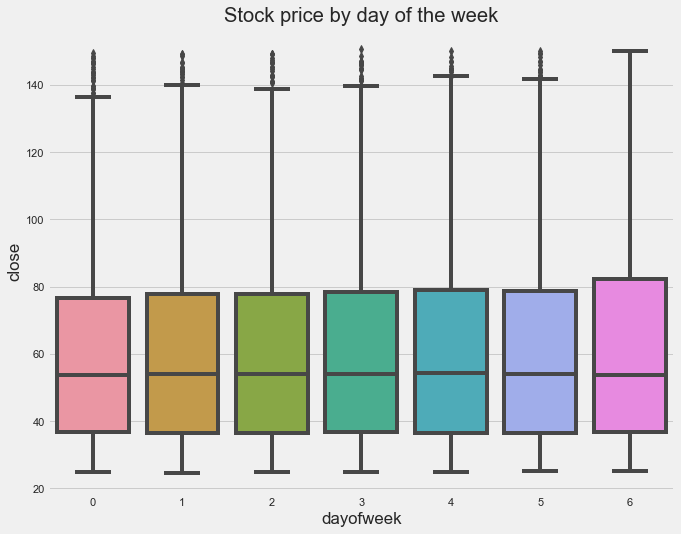

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Stock price by day of the week')
plt.show()

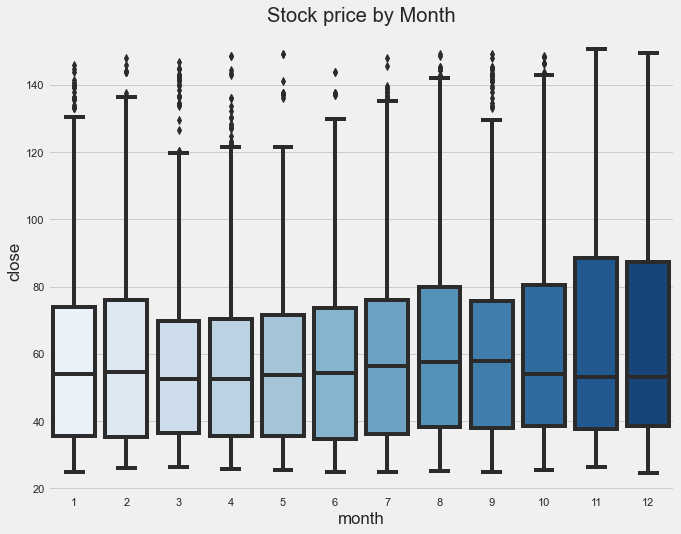

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('Stock price by Month')
plt.show()

# Create our Model¶


In [33]:
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','NASDAQ','Change']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:63.76313	validation_1-rmse:114.69882
[100]	validation_0-rmse:23.68171	validation_1-rmse:50.94649
[200]	validation_0-rmse:9.05382	validation_1-rmse:27.73641
[300]	validation_0-rmse:3.99434	validation_1-rmse:19.16465
[400]	validation_0-rmse:2.55615	validation_1-rmse:15.35639
[500]	validation_0-rmse:2.21705	validation_1-rmse:13.50264
[600]	validation_0-rmse:2.13000	validation_1-rmse:11.35049
[700]	validation_0-rmse:2.07172	validation_1-rmse:10.17506
[800]	validation_0-rmse:2.03113	validation_1-rmse:8.97660
[900]	validation_0-rmse:2.00018	validation_1-rmse:8.00849
[999]	validation_0-rmse:1.97622	validation_1-rmse:7.49827


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance¶


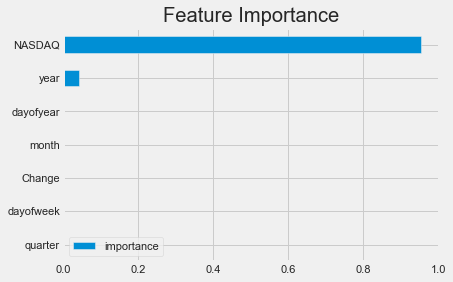

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test


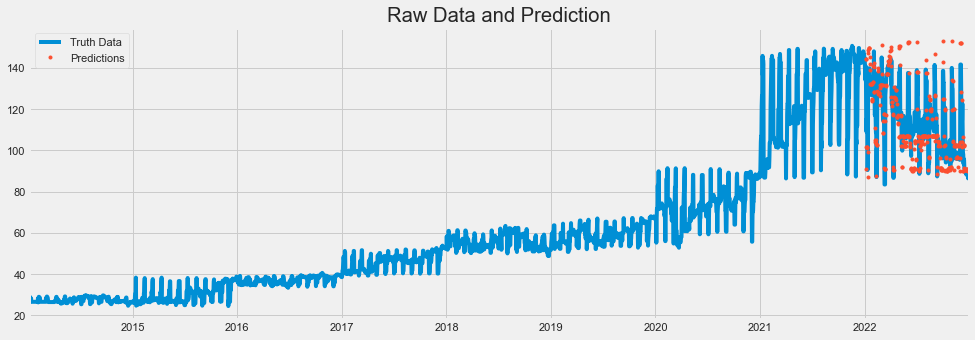

In [36]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [37]:
df['prediction'].tail(365)

2021-12-31           NaN
2022-01-01           NaN
2022-01-02           NaN
2022-01-03           NaN
2022-01-04    144.126389
                 ...    
2022-12-26     90.903015
2022-12-27     89.996101
2022-12-28     90.145203
2022-12-29     89.985588
2022-12-30     90.145203
Name: prediction, Length: 365, dtype: float32

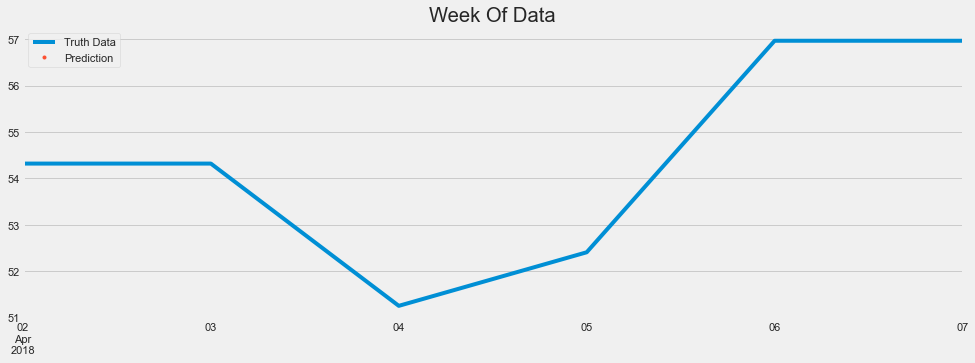

In [38]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [39]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 7.50


# Calculate error

In [40]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-06-22    20.637490
2022-06-21    20.432792
2022-06-30    18.153191
2022-01-07    18.137542
2022-06-17    17.816650
2022-06-20    17.572380
2022-06-18    17.572380
2022-06-19    17.572380
2022-06-29    16.713379
2022-06-28    16.644448
Name: error, dtype: float64

In [41]:
# report performance
mse = mean_squared_error(test['prediction'], test[TARGET])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['prediction'], test[TARGET])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['prediction'], test[TARGET]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test[TARGET] - test['prediction'])/np.abs(test['prediction']))
print('MAPE: '+str(mape))

MSE: 56.22407042746975
MAE: 5.946129400832918
RMSE: 7.498271162572727
MAPE: 0.0558359281981485


In [50]:
df=pd.read_csv("GOOGLE  BP DATA.csv")

In [51]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,27.859013,28.344681,27.859013,28.280355,158434.0,3.0,-0.007976,3658.399902
1,02-04-2014,29.917362,30.158699,28.032537,28.272379,2942055.0,4.0,0.136623,3665.989990
2,03-04-2014,28.414488,29.283602,28.129271,28.409002,101983228.0,5.0,-1.326357,3637.580078
3,04-04-2014,28.653831,28.809404,27.075665,27.082645,127386783.0,6.0,-0.248817,3539.379883
4,07-04-2014,26.962973,27.348913,26.285334,26.833828,88033033.0,2.0,0.835207,3507.750000


In [52]:
df=df["Close"]

In [55]:
df.head

<bound method NDFrame.head of 0       28.280355
1       28.272379
2       28.409002
3       27.082645
4       26.833828
          ...    
2262          NaN
2263          NaN
2264          NaN
2265          NaN
2266          NaN
Name: Close, Length: 2267, dtype: float64>

# Future prediction


In [56]:
# Create a date range for the next 365 days
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
date_range = pd.date_range(start_date, end_date)

# Make predictions for the future dates
future_predictions = reg.predict(df)  # Replace 'future_features' with your actual input data

# Create a DataFrame with the predictions and future dates
future_df = pd.DataFrame({'Date': date_range, 'Prediction': future_predictions})
future_df.set_index('Date', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the 'Prediction' data
ax.plot(future_df.index, future_df['Prediction'], label='Predictions', marker='.', linestyle='-', markersize=2)

# Set the title and labels for the axes
ax.set_title('Stock Price Predictions for the Next 365 Days')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Prices')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()








ValueError: feature_names mismatch: ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'NASDAQ', 'Change'] ['Close']
expected quarter, year, dayofweek, month, NASDAQ, dayofyear, Change in input data
training data did not have the following fields: Close